# 🩺 Model Training for Lung Cancer Detection 🫁


>I  optimized this code using AMP and GC 🚀⚡
>
>> __AMP (Automatic Mixed Precision)__ automatically mixes float16 and float32 data types in PyTorch, leveraging float16 for faster GPU computations and reduced memory while preserving float32 for critical operations to maintain accuracy, thus speeding up training and enabling larger models.
>
>> __GC (Garbage Collection)__ is Python's automatic memory management, reclaiming memory from unreferenced objects to prevent leaks and optimize memory footprint, ensuring efficient resource use during long training runs.

🛠️ __Parameters__ ⚙️

In [1]:
# dataset_path = "../Datasets/0. Raw/Mixed/"
dataset_path = '../Datasets/2.0 Raw Split/train/'
batch_size = 8
num_epochs = 50
dimension = 299
learing_rate = 0.0001
train_test_ratio = 0.18
patience=5
early_stopping=False
model_name = "InceptionV3_without_CLAHE_B"+str(batch_size)+"+E"+str(num_epochs)+""

⏳ Loading Basic Libraries  📦 📚

In [2]:
import os
import gc
import sys
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sys.path.append('../')

🎮 Using GPU if available  🖥️ 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Preprocessing 🧼 🧹

🏷️ Listing Classes 📊 Dynamically from `dataset_path` 🗂️ 

In [4]:
try:
    classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    if not classes:
        raise ValueError("No subdirectories found in the dataset path. Ensure your dataset is organized into class folders.")
    print(f"Discovered classes: {classes}")
except FileNotFoundError:
    print(f"Error: Dataset path '{dataset_path}' not found. Please check the path.")
    exit()
except ValueError as e:
    print(f"Error: {e}")
    exit()

Discovered classes: ['Bengin cases', 'Malignant cases', 'Normal cases']


Defining Functions to Visualize Data and Class Distribution ⚙️

In [5]:
# Function to visualize class distribution
def visualize_class_distribution(labels_data, class_names, title_suffix=""):
    plt.figure(figsize=(12, 6))
    sns.countplot(x=labels_data, hue=labels_data, palette="viridis", legend=False)
    # plt.title(f"Class Distribution {title_suffix}")
    plt.xlabel("Class Name")
    plt.ylabel("Count")
    plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    plt.close('all')
    gc.collect()

# Function to visualize example images from the loaded dataset
def visualize_loaded_example(data_array, labels_array, class_names, num_examples_per_class=1):
    print("\nVisualizing example images from loaded dataset...")
    n_rows = num_examples_per_class
    n_cols = len(class_names)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes[np.newaxis, :]
    elif n_cols == 1:
        axes = axes[:, np.newaxis]

    for i, cls_name in enumerate(class_names):
        class_indices = np.where(labels_array == i)[0]
        
        # Handle cases where a class might have fewer examples than num_examples_per_class
        if len(class_indices) < num_examples_per_class:
            print(f"Warning: Class '{cls_name}' has only {len(class_indices)} images, requested {num_examples_per_class}.")
            selected_indices = class_indices # Use all available images
        else:
            selected_indices = np.random.choice(class_indices, num_examples_per_class, replace=False)
        
        for j, idx in enumerate(selected_indices):
            img = data_array[idx] # 
            
            ax = axes[j][i]
            ax.imshow(img)
            ax.set_title(f"{cls_name}")
            ax.axis("off")
            
    plt.tight_layout()
    plt.show()
    plt.close('all')
    gc.collect()

🗂️  Loading Dataset 🖼️


Loading entire dataset...
Dataset loaded. Total images: 986
Initial data shape: (986, 299, 299, 3), labels shape: (986,)

Visualizing example images from loaded dataset...


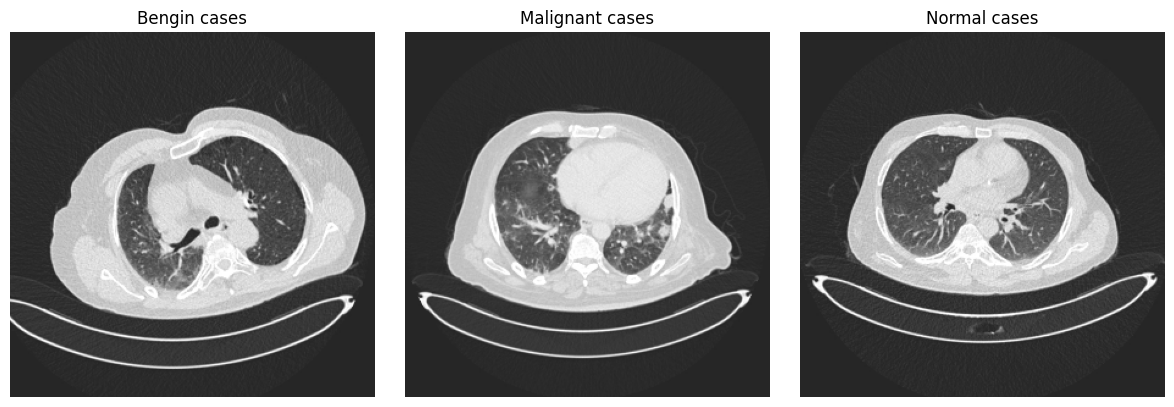


Visualizing initial class distribution...


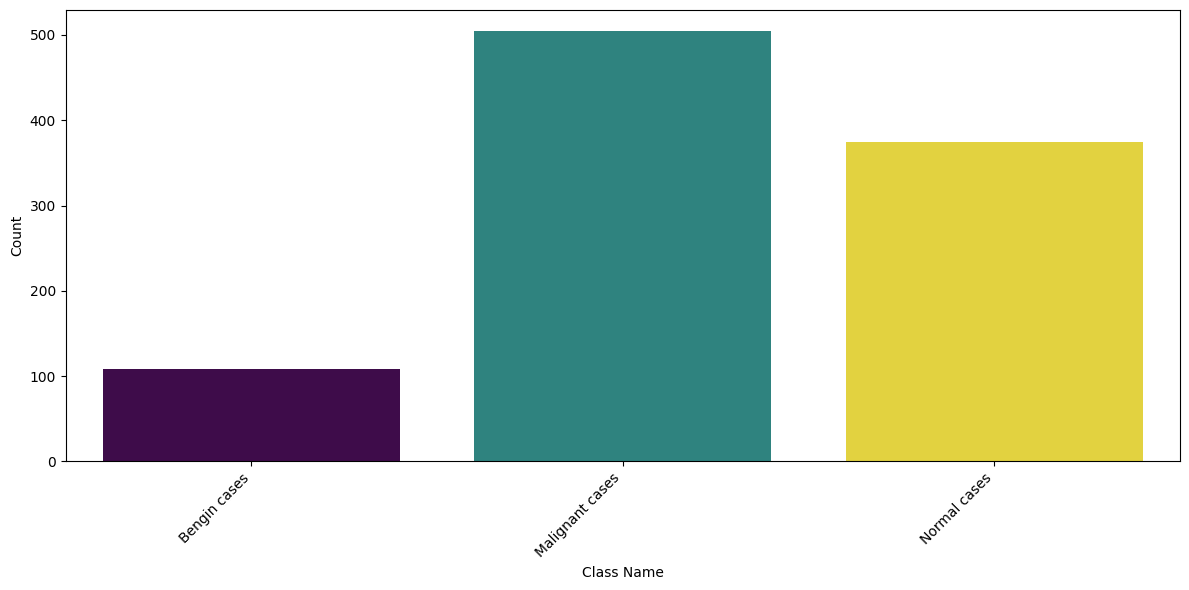

In [ ]:
# Function to visualize class distribution
def visualize_class_distribution(labels_data, class_names, title_suffix=""):
    plt.figure(figsize=(12, 6))
    sns.countplot(x=labels_data, hue=labels_data, palette="viridis", legend=False)
    # plt.title(f"Class Distribution {title_suffix}")
    plt.xlabel("Class Name")
    plt.ylabel("Count")
    plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    plt.close('all')
    gc.collect()

# Function to visualize example images from the loaded dataset
def visualize_loaded_example(data_array, labels_array, class_names, num_examples_per_class=1):
    print("\nVisualizing example images from loaded dataset...")
    n_rows = num_examples_per_class
    n_cols = len(class_names)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes[np.newaxis, :]
    elif n_cols == 1:
        axes = axes[:, np.newaxis]

    for i, cls_name in enumerate(class_names):
        class_indices = np.where(labels_array == i)[0]
        
        # Handle cases where a class might have fewer examples than num_examples_per_class
        if len(class_indices) < num_examples_per_class:
            print(f"Warning: Class '{cls_name}' has only {len(class_indices)} images, requested {num_examples_per_class}.")
            selected_indices = class_indices # Use all available images
        else:
            selected_indices = np.random.choice(class_indices, num_examples_per_class, replace=False)
        
        for j, idx in enumerate(selected_indices):
            img = data_array[idx] # 
            
            ax = axes[j][i]
            ax.imshow(img)
            ax.set_title(f"{cls_name}")
            ax.axis("off")
            
    plt.tight_layout()
    plt.show()
    plt.close('all')
    gc.collect()

Balancing - Applying SMOTE 📊

Balanced data shape: (1512, 299, 299, 3), balanced labels shape: (1512,)

Visualizing class distribution after SMOTE...


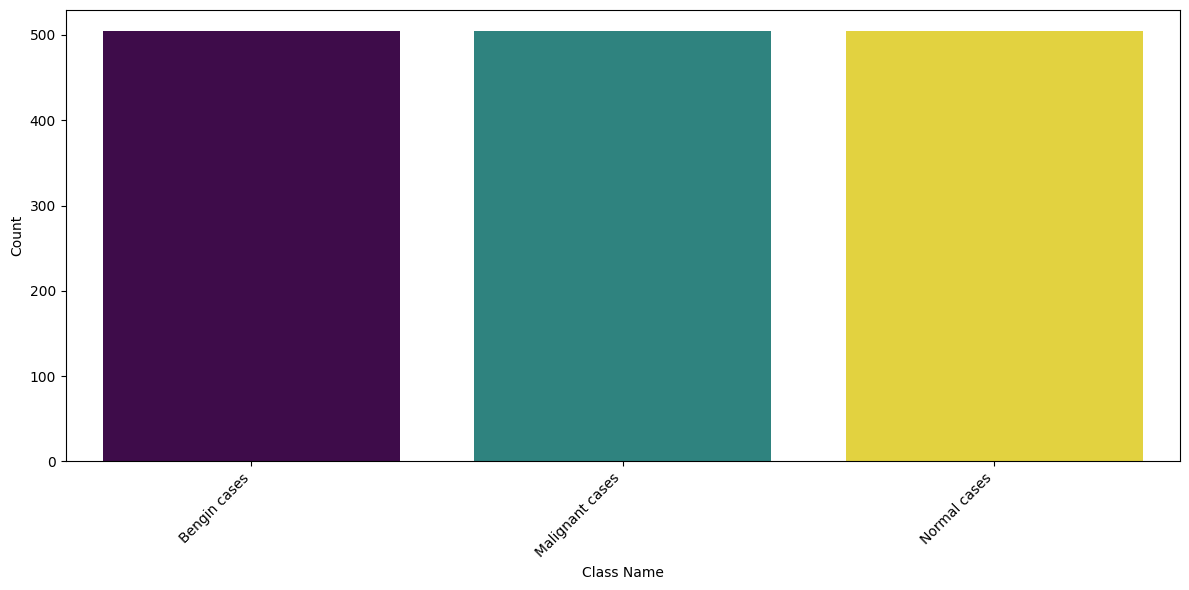

In [7]:
data_flat = all_data.reshape(len(all_data), -1).astype(np.float32)

del all_data
gc.collect()

smote = SMOTE(random_state=42)
data_balanced, labels_balanced = smote.fit_resample(data_flat, all_labels) # 'all_labels' is used here

del data_flat, all_labels
gc.collect()

data_balanced = data_balanced.reshape(-1, dimension, dimension, 3).astype(np.uint8)
print(f"Balanced data shape: {data_balanced.shape}, balanced labels shape: {labels_balanced.shape}")

print("\nVisualizing class distribution after SMOTE...")
visualize_class_distribution(labels_balanced, classes, "After SMOTE") # Pass 'classes' for labels

✂️ Splitting Data into Train - Test ➗

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data_balanced, labels_balanced, test_size=train_test_ratio, random_state=42, stratify=labels_balanced) # Add stratify for balanced split
print(f"Train data shape: {train_data.shape}, Test data shape: {test_data.shape}")

del data_balanced, labels_balanced
gc.collect()

Train data shape: (1239, 299, 299, 3), Test data shape: (273, 299, 299, 3)


2526

### 🧠 Modeling and Training 🏋️‍♂️

⬇️ Preparing Dataloaders 🗂️

In [9]:
transform = transforms.Compose([
    transforms.ToPILImage(), # Convert NumPy array to PIL Image for torchvision transforms
    transforms.ToTensor(), # Converts to tensor and scales to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

class EyeDiseaseDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        # Images are already in RGB from initial load
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img).permute(2, 0, 1).float() / 255.0
        return img, torch.tensor(label, dtype=torch.long)

train_dataset = EyeDiseaseDataset(train_data, train_labels, transform=transform)
test_dataset = EyeDiseaseDataset(test_data, test_labels, transform=transform)

del train_data, train_labels, test_data, test_labels
gc.collect()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count() // 2 or 1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count() // 2 or 1)
print("Datasets and DataLoaders prepared.")


Datasets and DataLoaders prepared.


🤖 Defining Model 📦

In [10]:
model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, len(classes)) 
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, len(classes))
model = model.to(device)

🧑‍🏫 Training 🏃‍♂️

In [11]:
def train_model(model, train_loader, test_loader, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learing_rate)

    scaler = torch.amp.GradScaler('cuda')

    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    print("Starting model training...")
    for epoch in range(num_epochs):
        model.train()  
        correct, total, running_loss = 0, 0, 0
        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                outputs, aux_outputs = model(imgs) 
                loss_main = criterion(outputs, labels)
                loss_aux = criterion(aux_outputs, labels)
                loss = loss_main + 0.4 * loss_aux

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        correct, total, running_loss = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)

                with torch.amp.autocast('cuda'): 
                    # FIX: In eval mode, outputs is a Tensor, so no .logits needed
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)  # <--- FIXED

                running_loss += loss.item()
                # FIX: In eval mode, outputs is a Tensor, so no .logits needed
                _, preds = torch.max(outputs, 1)  # <--- FIXED
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_loss.append(running_loss / len(test_loader))
        val_acc.append(correct / total)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}: Train Acc={train_acc[-1]:.4f}, Val Acc={val_acc[-1]:.4f}, "f"Train Loss={train_loss[-1]:.4f}, Val Loss={val_loss[-1]:.4f}, Learning Rate={current_lr:.6f}")

        if early_stopping:
            if val_loss[-1] < best_val_loss:
                best_val_loss = val_loss[-1]
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
            
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered. Validation loss has not improved for {patience} epochs.")
                break

    print("Model training complete.")
    return train_loss, val_loss, train_acc, val_acc

train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, test_loader, num_epochs=num_epochs)

Starting model training...
Epoch 1/50: Train Acc=0.8483, Val Acc=0.9853, Train Loss=0.5026, Val Loss=0.0542, Learning Rate=0.000100
Epoch 2/50: Train Acc=0.9645, Val Acc=0.9963, Train Loss=0.1663, Val Loss=0.0148, Learning Rate=0.000100
Epoch 3/50: Train Acc=0.9677, Val Acc=1.0000, Train Loss=0.1385, Val Loss=0.0139, Learning Rate=0.000100
Epoch 4/50: Train Acc=0.9774, Val Acc=0.9963, Train Loss=0.0942, Val Loss=0.0354, Learning Rate=0.000100
Epoch 5/50: Train Acc=0.9976, Val Acc=1.0000, Train Loss=0.0333, Val Loss=0.0029, Learning Rate=0.000100
Epoch 6/50: Train Acc=0.9927, Val Acc=0.9927, Train Loss=0.0464, Val Loss=0.0145, Learning Rate=0.000100
Epoch 7/50: Train Acc=0.9879, Val Acc=1.0000, Train Loss=0.0418, Val Loss=0.0030, Learning Rate=0.000100
Epoch 8/50: Train Acc=0.9895, Val Acc=0.9670, Train Loss=0.0416, Val Loss=0.0671, Learning Rate=0.000100
Epoch 9/50: Train Acc=0.9919, Val Acc=0.9963, Train Loss=0.0449, Val Loss=0.0062, Learning Rate=0.000100
Epoch 10/50: Train Acc=0.993

📥 Saving the model 💾

In [12]:
from Functions.model_save import save_training_artifacts
save_training_artifacts(model, test_loader, train_loss, val_loss, train_acc, val_acc, classes, model_name, device)

if device.type == 'cuda':
    torch.cuda.empty_cache()
gc.collect()

Model saved to: ../saved_models/InceptionV3_without_CLAHE_B8+E50_model.pth
Results saved to: ../saved_results/InceptionV3_without_CLAHE_B8+E50/InceptionV3_without_CLAHE_B8+E50_results.json
Confusion Matrix plot saved to: ../saved_results/InceptionV3_without_CLAHE_B8+E50/InceptionV3_without_CLAHE_B8+E50_confusion_matrix.png
Multi-class ROC Curve plot saved to: ../saved_results/InceptionV3_without_CLAHE_B8+E50/InceptionV3_without_CLAHE_B8+E50_multi_class_roc_curve.png


0

### 🔍 Result 📊

Collecting Test Results from Model 📦

In [13]:
model.eval()
y_true = []
y_pred = []
all_outputs = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(imgs)

            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            all_outputs.extend(outputs.cpu().numpy())

del imgs, labels, outputs, preds
if device.type == 'cuda':
    torch.cuda.empty_cache()
gc.collect()

7951

🔢 Confusion Matrix 📊

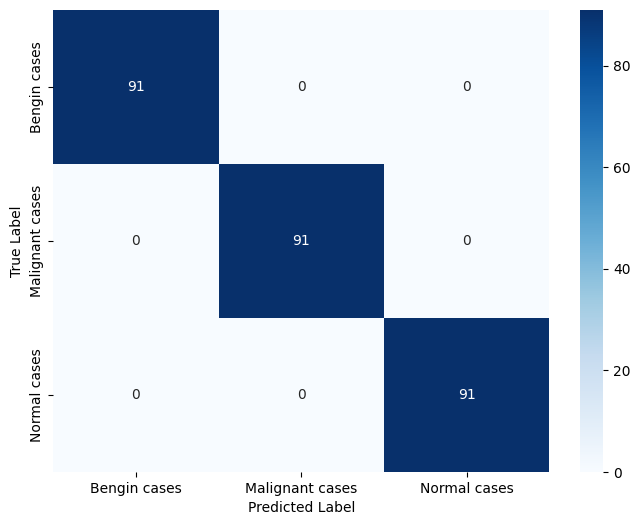

In [14]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# plt.title("Confusion Matrix")
plt.show()
plt.close("all")

📄 Classification Report 

In [15]:
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

n_classes = len(classes)
total_samples = np.sum(cm)

metrics_data_raw = []

sum_TP_ovr = 0
sum_FN_ovr = 0
sum_FP_ovr = 0
sum_TN_ovr = 0

for i, class_name in enumerate(classes):

    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = total_samples - TP - FN - FP

    sum_TP_ovr += TP
    sum_FN_ovr += FN
    sum_FP_ovr += FP
    sum_TN_ovr += TN

    TPR_Recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    TNR_Specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0

    Accuracy_per_class = (TP + TN) / total_samples if total_samples > 0 else 0

    precision = report[class_name]["precision"]
    recall = report[class_name]["recall"]
    f1 = report[class_name]["f1-score"]
    support = report[class_name]["support"]

    metrics_data_raw.append(
        {
            "Class": class_name,
            "Test Data Count": support,
            "TP": TP,
            "TN": TN,
            "FP": FP,
            "FN": FN,
            "TPR (Recall)": TPR_Recall,
            "TNR (Specificity)": TNR_Specificity,
            "FPR": FPR,
            "FNR": FNR,
            "Accuracy": Accuracy_per_class,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
        }
    )

df_metrics_raw = pd.DataFrame(metrics_data_raw)

avg_TPR_Recall = (
    sum_TP_ovr / (sum_TP_ovr + sum_FN_ovr) if (sum_TP_ovr + sum_FN_ovr) > 0 else 0
)
avg_TNR_Specificity = (
    sum_TN_ovr / (sum_TN_ovr + sum_FP_ovr) if (sum_TN_ovr + sum_FP_ovr) > 0 else 0
)
avg_FPR = sum_FP_ovr / (sum_FP_ovr + sum_TN_ovr) if (sum_FP_ovr + sum_TN_ovr) > 0 else 0
avg_FNR = sum_FN_ovr / (sum_FN_ovr + sum_TP_ovr) if (sum_FN_ovr + sum_TP_ovr) > 0 else 0

average_row = {
    "Class": "Average (Micro)",
    "Test Data Count": total_samples,  # Total samples
    "TP": sum_TP_ovr,
    "TN": sum_TN_ovr,
    "FP": sum_FP_ovr,
    "FN": sum_FN_ovr,
    "TPR (Recall)": avg_TPR_Recall,
    "TNR (Specificity)": avg_TNR_Specificity,
    "FPR": avg_FPR,
    "FNR": avg_FNR,
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": report["weighted avg"]["precision"],  
    "Recall": report["weighted avg"]["recall"], 
    "F1-Score": report["weighted avg"]["f1-score"],  
}

df_metrics = pd.concat([df_metrics_raw, pd.DataFrame([average_row])], ignore_index=True)

for col in df_metrics.columns:
    if col not in ["Class", "Test Data Count", "TP", "TN", "FP", "FN"]:
        df_metrics[col] = df_metrics[col].apply(
            lambda x: f"{x:.4f}" if isinstance(x, (float, np.float64)) else x
        )

print(df_metrics.to_string(index=False))  # Use to_string to prevent truncation

          Class  Test Data Count  TP  TN  FP  FN TPR (Recall) TNR (Specificity)    FPR    FNR Accuracy Precision Recall F1-Score
   Bengin cases             91.0  91 182   0   0       1.0000            1.0000 0.0000 0.0000   1.0000    1.0000 1.0000   1.0000
Malignant cases             91.0  91 182   0   0       1.0000            1.0000 0.0000 0.0000   1.0000    1.0000 1.0000   1.0000
   Normal cases             91.0  91 182   0   0       1.0000            1.0000 0.0000 0.0000   1.0000    1.0000 1.0000   1.0000
Average (Micro)            273.0 273 546   0   0       1.0000            1.0000 0.0000 0.0000   1.0000    1.0000 1.0000   1.0000


💾 Saving Classification Result as CSV 📂

In [16]:
results_dir = f"../saved_results/{model_name}/"
os.makedirs(results_dir + f"", exist_ok=True)

csv_filename = results_dir + model_name + ".csv"
df_metrics.to_csv(csv_filename, index=False)
print(f"\n✅ Detailed metrics saved to {csv_filename}")

del (
    y_true,
    y_pred,
    cm,
    all_outputs,
    report,
    df_metrics,
    metrics_data_raw,
    average_row,
    sum_TP_ovr,
    sum_FN_ovr,
    sum_FP_ovr,
    sum_TN_ovr,
)
gc.collect()


✅ Detailed metrics saved to ../saved_results/InceptionV3_without_CLAHE_B8+E50/InceptionV3_without_CLAHE_B8+E50.csv


0

📈 Training Curves 📉 

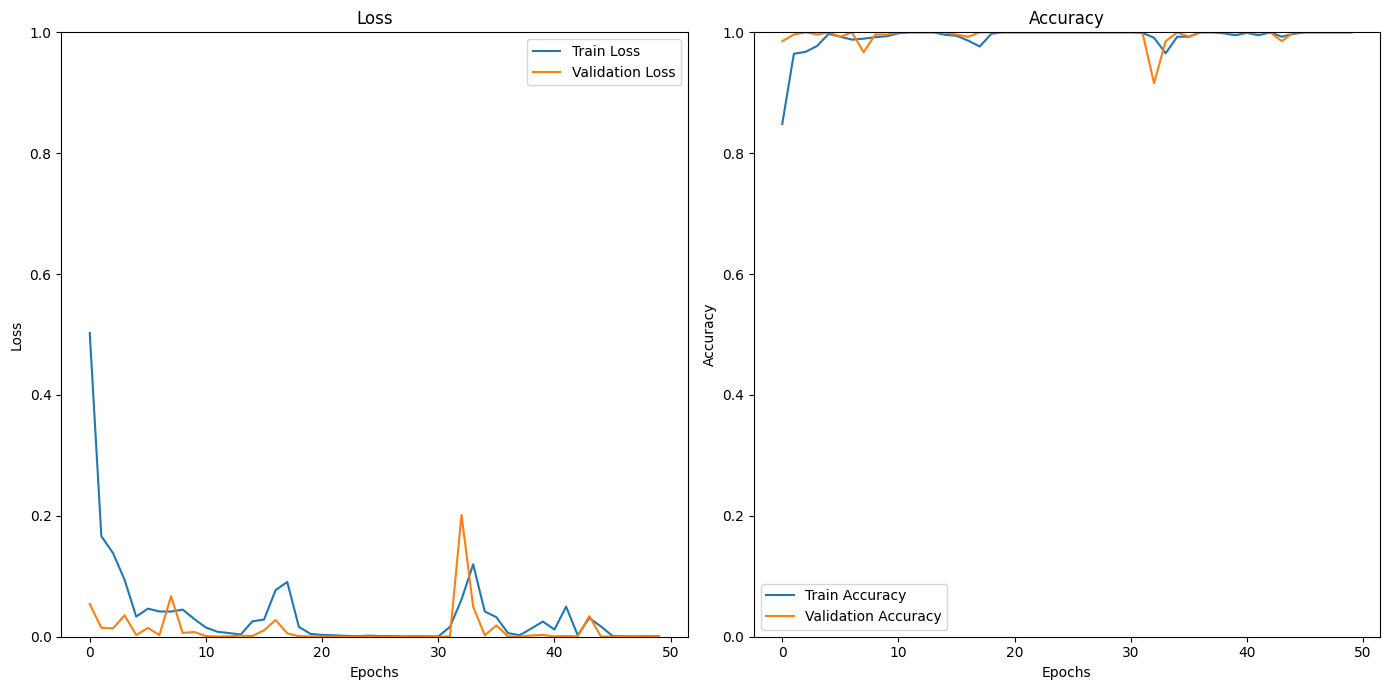

6202

In [17]:
def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(14, 7)) 

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    max_observed_loss = max(max(train_loss), max(val_loss))
    if max_observed_loss < 1.0:
        plt.ylim(0, 1) # Set range from 0 to 1 if max loss is less than 1


    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()
    plt.close('all')

plot_training_curves(train_loss, val_loss, train_acc, val_acc)

del train_loss, val_loss, train_acc, val_acc
gc.collect()

### 👁️  XAI 📸 🌈 

🔧 XAI Parameters ⚙️

In [ ]:
max_samples_per_class = 2
total_classes = len(classes)
alpha = 0.5
beta = 0.5 

target_layers_to_test = [
    ("Mixed_7c", model.Mixed_7c), 
]

XAI Functions 🧮


--- Visualizing Grad-CAM++ for Class: Bengin cases ---
  -> Sample 1/2
    -> Generating Grad-CAM++ for layer: Mixed_7c


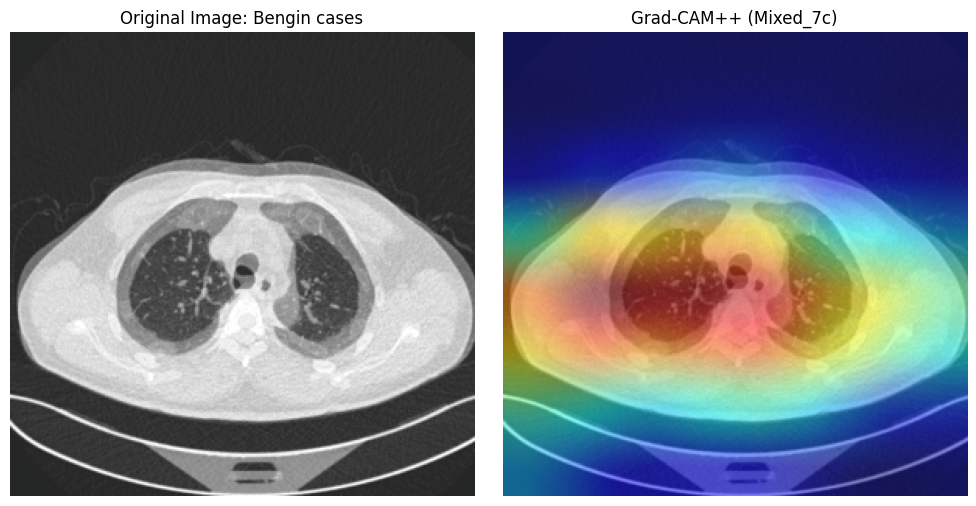

  -> Sample 2/2
    -> Generating Grad-CAM++ for layer: Mixed_7c


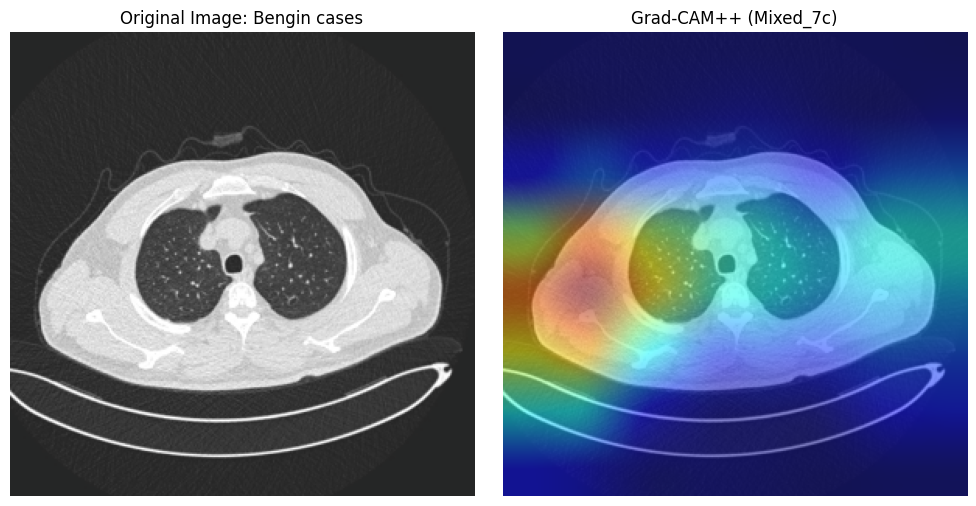


--- Visualizing Grad-CAM++ for Class: Malignant cases ---
  -> Sample 1/2
    -> Generating Grad-CAM++ for layer: Mixed_7c


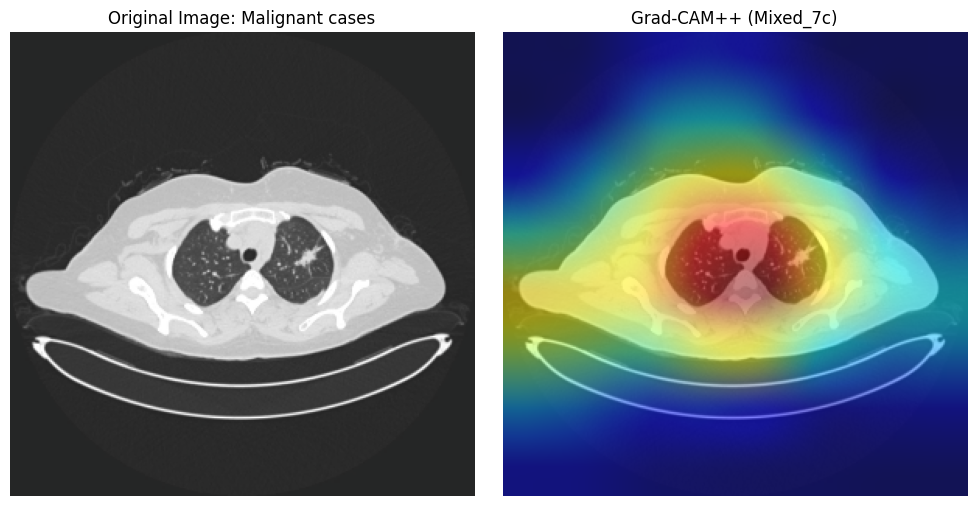

  -> Sample 2/2
    -> Generating Grad-CAM++ for layer: Mixed_7c


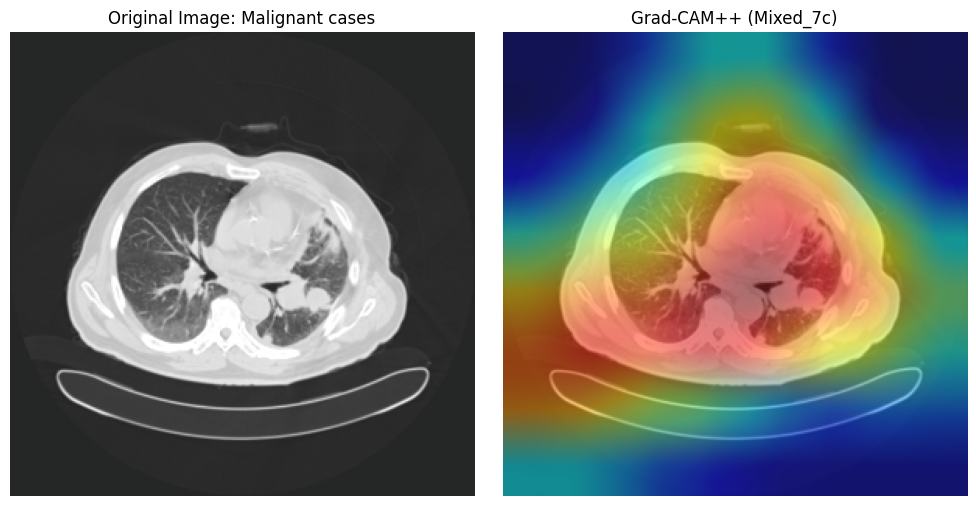


--- Visualizing Grad-CAM++ for Class: Normal cases ---
  -> Sample 1/2
    -> Generating Grad-CAM++ for layer: Mixed_7c


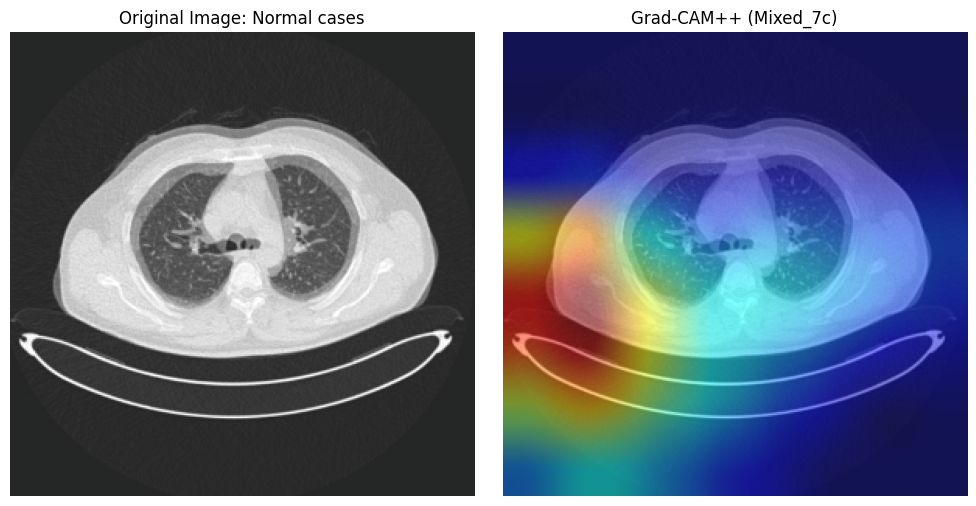

  -> Sample 2/2
    -> Generating Grad-CAM++ for layer: Mixed_7c


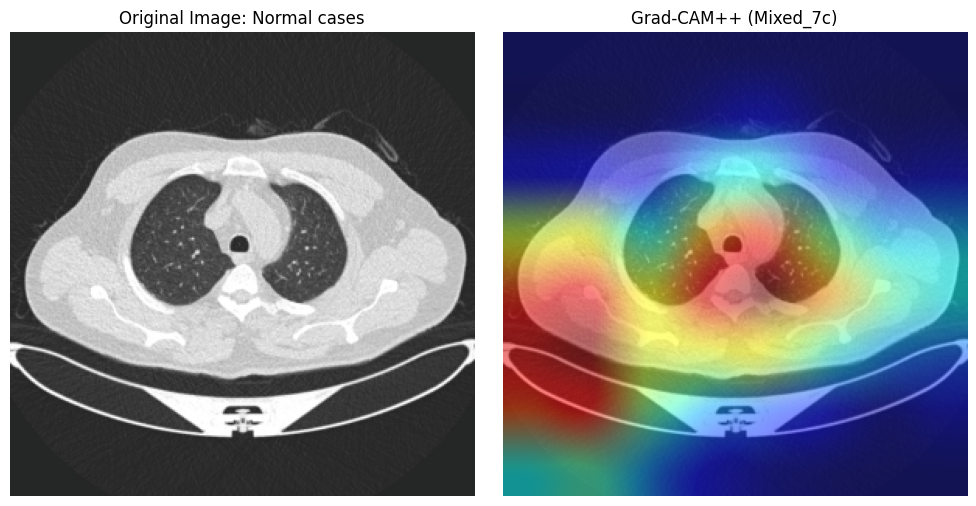


Grad-CAM++ visualizations complete for selected layers, grouped by class.


In [ ]:
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None # Activations will now be kept in the graph

        # Register forward hook to capture activations. IMPORTANT: Do NOT detach here.
        # We need the activations to be part of the computation graph for gradient computation later.
        self.hook_forward = self.target_layer.register_forward_hook(self._save_activation)

    def _save_activation(self, module, input, output):
        # Store activations; they remain attached to the graph for gradient computation later.
        self.activations = output

    def generate_heatmap(self, gradients, activations, device):
        # --- Grad-CAM++ specific calculation for weights (alphas) ---
        # Gradients passed here are the first-order gradients (dY/dA) from __call__
        
        # Ensure tensors are on the correct device
        if activations.device != device:
            activations = activations.to(device)
        if gradients.device != device:
            gradients = gradients.to(device)

        # Calculate alpha_kc as per Grad-CAM++ paper (simplified for practical implementation)
        # This involves element-wise operations on gradients.
        
        # Element-wise squared gradients
        grad_squared = gradients.pow(2)
        # Element-wise cubed gradients
        grad_cubed = gradients.pow(3)
        
        # Sum gradients across spatial dimensions (height and width) for normalization
        sum_grad = gradients.sum(dim=(-1,-2), keepdim=True) # Sum over H, W
        
        # Avoid division by zero by adding a small epsilon
        epsilon = 1e-7

        # Calculate alpha_num and alpha_den (numerator and denominator for alpha_kc)
        alpha_num = grad_squared # Numerator for alpha_kc
        alpha_den = 2 * grad_squared + sum_grad * grad_cubed # Denominator for alpha_kc
        alpha_den[alpha_den < epsilon] = epsilon # Handle near-zero denominators

        # Calculate alpha_kc (element-wise importance weights for each pixel of each channel)
        alpha_kc = alpha_num / alpha_den
        
        # Element-wise multiply alpha_kc with ReLU(gradients)
        # This emphasizes positive contributions and focuses on relevant gradients
        weights_channel_wise = (alpha_kc * torch.relu(gradients)).sum(dim=(-1,-2), keepdim=True)
        # The sum over spatial dims (H, W) for `weights_channel_wise` aggregates pixel importance for each channel.

        # The final heatmap is the weighted sum of activations
        heatmap = (weights_channel_wise * activations).sum(dim=1, keepdim=True)
        heatmap = torch.relu(heatmap) # Apply ReLU again to the final heatmap

        # Move to CPU, detach from graph, convert to NumPy, and normalize to [0, 1]
        heatmap = heatmap.squeeze().cpu().detach().numpy()
        if np.max(heatmap) > 0:
            heatmap = heatmap / np.max(heatmap)
        return heatmap


    def __call__(self, input_img, target_class_idx):
        self.model.zero_grad() # Crucial: Zero gradients for the model before any passes

        # Ensure input image has requires_grad=True for gradient computation
        input_img_requires_grad = input_img.clone().requires_grad_(True)
        
        # Forward pass through the model
        with torch.amp.autocast('cuda'):
            output = self.model(input_img_requires_grad)
            
            # EfficientNet models do not return InceptionOutputs, so this check is removed.
            # if isinstance(output, models.inception.InceptionOutputs):
            #     output = output.logits
            
            # Validate target_class_idx
            if target_class_idx >= output.size(1):
                raise ValueError(f"target_class_idx ({target_class_idx}) out of bounds for model output with {output.size(1)} classes.")

            # Select the score for the specific target class for backpropagation
            class_score = output[0, target_class_idx]
        
        # Compute first-order gradients of the class score with respect to the target layer's activations.
        # `retain_graph=True` is vital here because we need the graph to remain for further operations
        # within `generate_heatmap` (if using full Grad-CAM++), or simply to allow subsequent `grad()` calls.
        gradients = torch.autograd.grad(
            class_score, self.activations, retain_graph=True, allow_unused=True
        )[0] # Added allow_unused=True to handle cases where a layer might not contribute gradients for a specific path

        # Generate the heatmap using the computed gradients and activations.
        # Detach activations and gradients before passing them to generate_heatmap
        # as generate_heatmap performs numpy operations.
        heatmap = self.generate_heatmap(
            gradients.detach(),
            self.activations.detach(),
            device=input_img_requires_grad.device,
        )
        
        # Clear stored activations to free memory and prepare for next call.
        self.activations = None
        
        return heatmap

    def remove_hooks(self):
        """Removes the forward hook."""
        self.hook_forward.remove()


# --- Visualization Function ---
def visualize_gradcam(model, grad_cam_instance, img, label, class_names, layer_name=""):
    model.eval() # Set model to evaluation mode

    img_tensor = img.unsqueeze(0).to(device)
    
    # Denormalization values (Assuming ImageNet normalization)
    # IMPORTANT: Adjust these if your medical images were normalized with different mean/std values.
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    
    img_display = img_tensor.squeeze(0).cpu()
    img_display = img_display * std.cpu() + mean.cpu()
    img_display = img_display.permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)

    heatmap = grad_cam_instance(img_tensor, label.item())

    h, w, _ = img_display.shape 
    
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_resized = cv2.resize(heatmap, (w, h), interpolation=cv2.INTER_CUBIC)
    heatmap_rgb = cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB)
    
    # Convert heatmap_rgb to float32 and scale to [0, 1] to match img_display type and range
    heatmap_rgb = np.float32(heatmap_rgb) / 255

    # Create an overlay by blending the original image and the heatmap
    
    overlay = cv2.addWeighted(np.float32(img_display), alpha, heatmap_rgb, beta, 0)
    overlay = overlay / np.max(overlay)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image: {class_names[label.item()]}")
    plt.imshow(img_display)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM++ ({layer_name})")
    plt.imshow(overlay)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close('all')

    del img_tensor, img_display, heatmap, heatmap_resized, heatmap_rgb, overlay, mean, std
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    gc.collect()




collected_samples = {class_idx: [] for class_idx in range(total_classes)}
samples_collected_count = {class_idx: 0 for class_idx in range(total_classes)}
all_samples_collected = False

for i, (img, label) in enumerate(test_loader):
    current_label = label[0].item() # Assuming batch_size=1 for Grad-CAM visualization

    if samples_collected_count[current_label] < max_samples_per_class:
        collected_samples[current_label].append((img[0].cpu(), label[0].cpu())) # Store on CPU to save GPU memory
        samples_collected_count[current_label] += 1
    
    # Check if we have collected enough samples for all classes
    if all(count >= max_samples_per_class for XAIcount in samples_collected_count.values()):
        all_samples_collected = True
        break

if not all_samples_collected:
    print("Warning: Not enough samples in test_loader to collect max_samples_per_class for all classes.")
    print("Visualizing with available samples.")


# Step 2: Iterate through classes and visualize collected samples
for class_idx in range(total_classes):
    class_name = classes[class_idx]
    
    if not collected_samples[class_idx]:
        print(f"\n--- No samples collected for Class: {class_name}. Skipping. ---")
        continue

    print(f"\n--- Visualizing Grad-CAM++ for Class: {class_name} ---")
    
    for sample_idx, (img_sample, label_sample) in enumerate(collected_samples[class_idx]):
        print(f"  -> Sample {sample_idx + 1}/{len(collected_samples[class_idx])}")
        
        # Loop through each defined target layer for the current sample
        for layer_name, target_layer_module in target_layers_to_test:
            print(f"    -> Generating Grad-CAM++ for layer: {layer_name}")
            
            # Create a new GradCam instance for each layer to ensure clean hooks
            grad_cam_instance = GradCam(model, target_layer=target_layer_module)
            
            # Visualize the Grad-CAM for the current layer and sample
            visualize_gradcam(model, grad_cam_instance, img_sample, label_sample, classes, layer_name=layer_name)
            
            # IMPORTANT: Remove hooks to prevent memory leaks and ensure correct behavior for subsequent GradCam instances
            grad_cam_instance.remove_hooks()
            del grad_cam_instance # Explicitly delete the instance to aid garbage collection
            gc.collect() # Force garbage collection after each visualization

print("\nGrad-CAM++ visualizations complete for selected layers, grouped by class.")